In [21]:
import argparse
import os
import random
import shutil
import time
import warnings
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.nn.functional as F

from torch.utils import data
import random
import numpy as np
from itertools import product
import argparse

from train_f import *
from Dataset import Dataset
#from Models import *
# from Models2 import *
# from Models4 import *
from args import args
from Models import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [22]:
import matplotlib.pyplot as plt

##add on after defining Dataloader and Model

def visualize(predicted,target,inputs):
#     outputs = F.softmax(output, dim=1)
#     predicted = outputs.max(1, keepdim=True)[1]
    
    fig, axs = plt.subplots(4,8,figsize=(15,7))
    axs = axs.reshape(-1)
    fig.suptitle('Prediction')
    for i in range(32):
        img_arr = predicted[0,0,i,:,:]
        axs[i].imshow(img_arr, cmap='hot')
        axs[i].set_title('%d'%i)
        axs[i].set_axis_off()
        
    fig, axs = plt.subplots(4,8,figsize=(15,7))
    axs = axs.reshape(-1)
    fig.suptitle('Targets')
    for i in range(32):
        img_arr = target[0,i,:,:]
        axs[i].imshow(img_arr, cmap='hot')
        axs[i].set_title('%d'%i)
        axs[i].set_axis_off()
    plt.show()

In [23]:
def validate(val_loader, model, criterion, target_class, save_name):
    TRAIN_LOSS,VAL_LOSS, VAL_ACC, VAL_RECALL, VAL_PRECISION = [],[],[],[],[]
    BEST_VAL_LOSS = 999999999
    BEST_RECALL = 0
    BEST_PRECISION = 0
    BEST_F1SCORE = 0
    BEST_ACC = 0
    EPSILON = 1e-5
    batch_time = AverageMeter()
    val_losses = AverageMeter()
    TPRs = AverageMeter()
    FPRs = AverageMeter()  
    total = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.unsqueeze(dim = 1).to(device).float()
            if target_class == 0:
                target = target.to(device).long()
            elif target_class == 1:
                target = target.to(device).float()
            
            
            # compute output
#             output = model(input)
            if target_class == 0:
#                 outputs = F.softmax(output, dim=1)
                predicted = outputs.max(1)[1]
                total += np.prod(target.shape)
                correct += predicted.eq(target.view_as(predicted)).sum().item()
                TPR, gp, FPR, gf = confusion_matrix_calc(predicted,target)
                TPRs.update(TPR,gp)
                FPRs.update(FPR,gf)
            loss = criterion(output, target)
            # measure accuracy and record loss
            val_losses.update(loss.item(), input.size(0))

    
    if target_class == 0:
        recall = TPRs.avg * 100
        precision = TPRs.sum/(TPRs.sum + FPRs.sum + EPSILON) * 100
        F1score = 2*((precision*recall)/(precision+recall+ EPSILON))
        acc = correct/total*100
        VAL_RECALL.append(recall)
        VAL_ACC.append(acc)
        VAL_PRECISION.append(precision)
        if val_losses.avg < BEST_VAL_LOSS:
            if len(save_name) > 0:
                #torch.save(model, 'pretrained/' + str(save_name) + '.pt')
                torch.save(model.state_dict(), 'pretrained/' + str(save_name) + '.pth')
            BEST_VAL_LOSS = val_losses.avg
            BEST_RECALL = recall
            BEST_PRECISION = precision
            BEST_F1SCORE = F1score
            BEST_ACC = acc
    
    VAL_LOSS.append(val_losses.avg)
    if target_class == 0:
        print('Test Loss {val_losses.avg:.4f},\
         Test Accuracy {acc:.4f},  Test Recall {recall:.4f}\t Precision {precision:.4f} F1 score  {F1score:.4f}\t'.format( \
            val_losses=val_losses,acc=acc, recall = recall, precision = precision, F1score = F1score))
    else:
        print('Test Loss {val_losses.avg:.4f}'\
            .format(val_losses=val_losses))

In [24]:
#!!!!!
filename = 'full_3_60_10'

In [25]:
dim = 1
model = R2Unet(dim, dim, t = 3).to(device)
state_dict = torch.load('../pretrained/model_' + filename + '.pth')
model.load_state_dict(state_dict)
#model = torch.load('../pretrained/yqloss_all_60_80.pt')

In [26]:
output = model(input)
outputs = F.softmax(output, dim=1)

TypeError: conv3d(): argument 'input' (position 1) must be Tensor, not method

In [15]:
thres = torch.Tensor([0.5]).to(device)

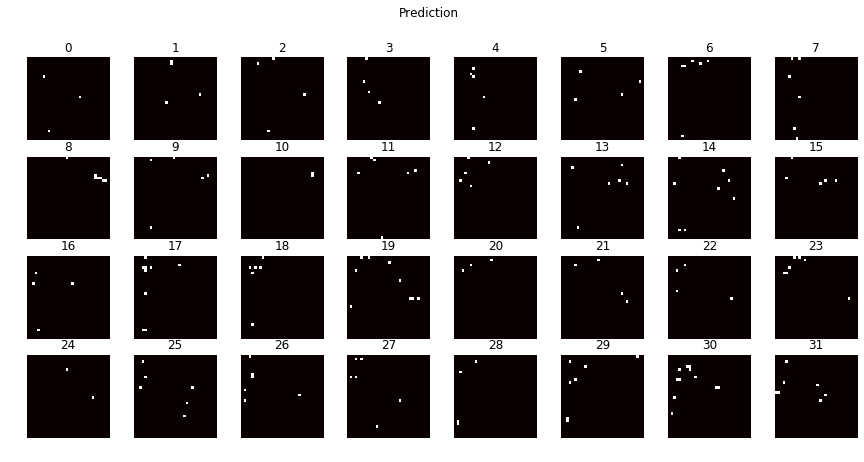

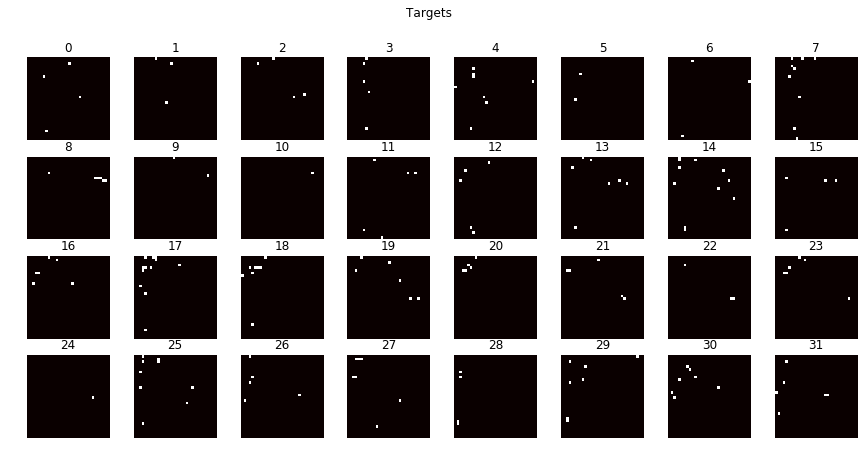

In [6]:
#test_data=[(736, 256, 288), (480, 480, 544), (608, 736, 736), (480, 928, 32)]
test_data=[(480, 480, 544)]
# #build dataloader
params = {'batch_size': 1,
      'shuffle': False,
      'num_workers' :20}
testing_set= Dataset(test_data)
testing_generator = data.DataLoader(testing_set, **params)

model.eval()
with torch.no_grad():
    for i, (inputs, target) in enumerate(testing_generator):
        inputs = inputs.unsqueeze(dim = 1).to(device).float()
        target = target.to(device).long()  
        output = model(inputs)
        outputs = F.softmax(output, dim=1)
        outputs_flat = outputs[:,1,:].view(-1)
        volumn = outputs_flat.size(0)
        predicted = torch.Tensor(volumn).to(device)

        for i in range(outputs_flat.size(0)):
            if outputs_flat[i] > thres:
                predicted[i] = 1
            else:
                predicted[i] = 0
        dm_mean=5.614541471004486
        predicted = predicted.view(target.size(0),1,32,32,32)
        visualize(predicted,target,inputs) #*dm_mean+dm_mean)
        

In [10]:
dark=np.load('/scratch/xz2139/cosmo_dark/Dark_zeros.npy')
dm_mean=5.614541471004486
dark=(dark-dm_mean)/dm_mean
predictions=np.zeros((2,1024,1024,1024))
data_range = 1024
pos=list(np.arange(0,data_range,32))
ranges=list(product(pos,repeat=3))


In [11]:

with torch.no_grad():
    for ID in ranges:
        inp=dark[ID[0]:ID[0]+32,ID[1]:ID[1]+32,ID[2]:ID[2]+32]
        inputs=torch.from_numpy(inp).unsqueeze(dim = 0).unsqueeze(dim = 1).to(device).float()
        output = model(inputs)
        outputs = F.softmax(output, dim=1)
#     predicted = outputs.max(1, keepdim=True)[1]
        predictions[:,ID[0]:ID[0]+32,ID[1]:ID[1]+32,ID[2]:ID[2]+32]=outputs.cpu().numpy()[0]
        if (ID[1]==0 and ID[2]==0):
            print(ID)
np.save('/scratch/ys3202/predictions_2' + filename + '.npy', predictions)

(0, 0, 0)
(32, 0, 0)
(64, 0, 0)
(96, 0, 0)
(128, 0, 0)
(160, 0, 0)
(192, 0, 0)
(224, 0, 0)
(256, 0, 0)
(288, 0, 0)
(320, 0, 0)
(352, 0, 0)
(384, 0, 0)
(416, 0, 0)
(448, 0, 0)
(480, 0, 0)
(512, 0, 0)
(544, 0, 0)
(576, 0, 0)
(608, 0, 0)
(640, 0, 0)
(672, 0, 0)
(704, 0, 0)
(736, 0, 0)
(768, 0, 0)
(800, 0, 0)
(832, 0, 0)
(864, 0, 0)
(896, 0, 0)
(928, 0, 0)
(960, 0, 0)
(992, 0, 0)


In [17]:

directory = '../fig/' + filename
if not os.path.exists(directory):
    os.makedirs(directory)
    
#dark=np.load('/scratch/xz2139/cosmo_dark/Dark_zeros.npy')
pred=np.load('/scratch/ys3202/predictions_' + filename + '.npy')
# predin=np.argmax(pred,axis=0)
full=np.load('/scratch/xz2139/cosmo_full/Full_zeros.npy')
#dark2=(dark-5.6)/5.6

d=60

for i in range(80,960,60):
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs = axs.reshape(-1)
    #fig.suptitle('axis_'+str(i))
    axs[0].imshow(np.log2(dark[i-d:i+d,i,i-d:i+d]+1), cmap='gist_gray')
    axs[0].set_title('Dark Matters from Simulation')
    axs[1].imshow(np.log(full[i-d:i+d,i,i-d:i+d]+1), cmap='gist_gray')
    axs[1].set_title('Subhalos from Simulation')
    axs[2].imshow(pred[1,i-d:i+d,i,i-d:i+d], cmap='gist_gray')
    axs[2].set_title('Predicted Probability Distribution for Galaxies')  
    
    fig.savefig('../fig/' + filename + '/axis_'+str(i)+'_pred_2.png')   # save the figure to file
    plt.close(fig) 

/home/ys3202/.conda/envs/dark/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2


/home/ys3202/.conda/envs/dark/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


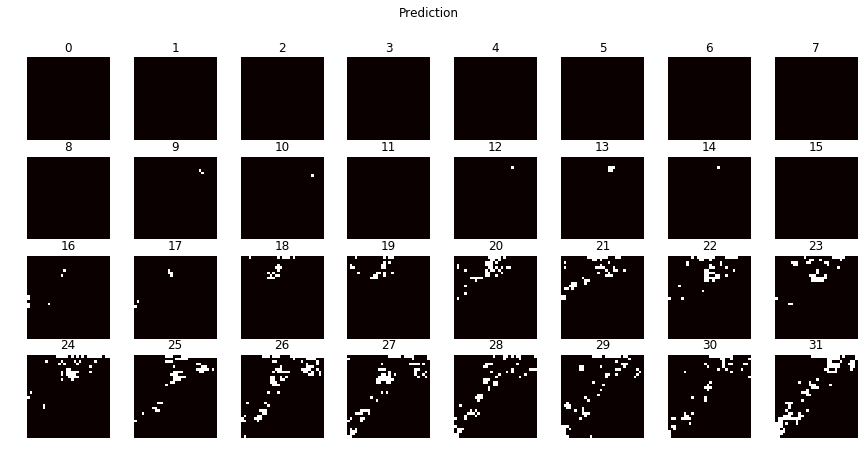

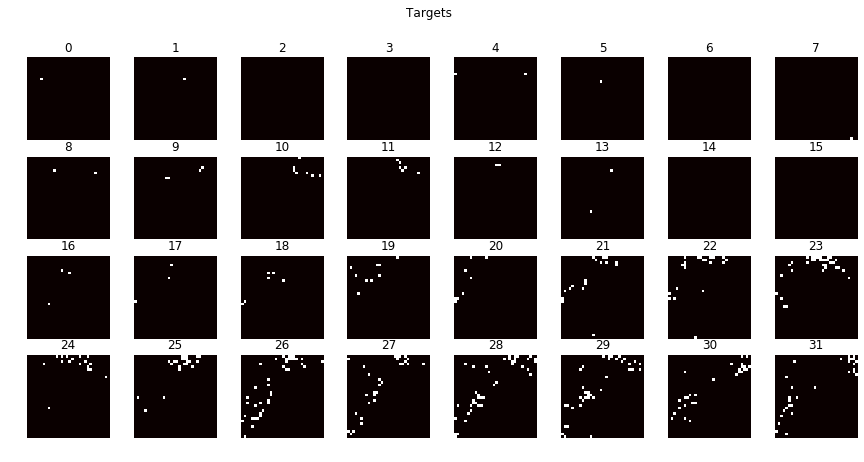

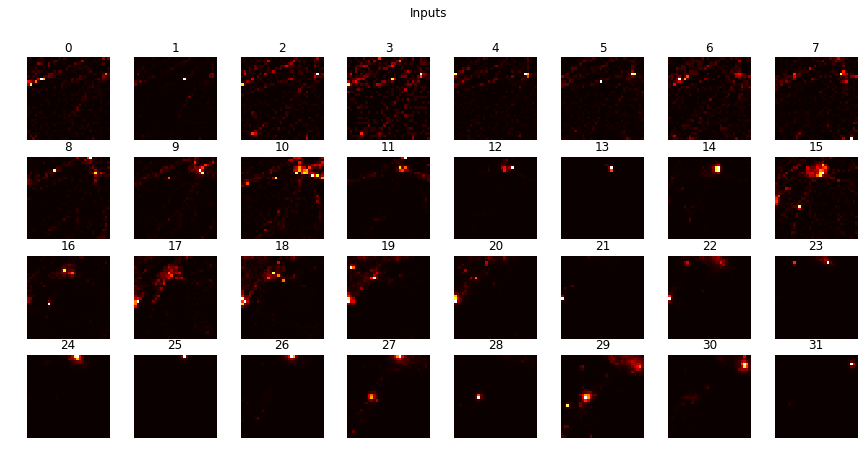

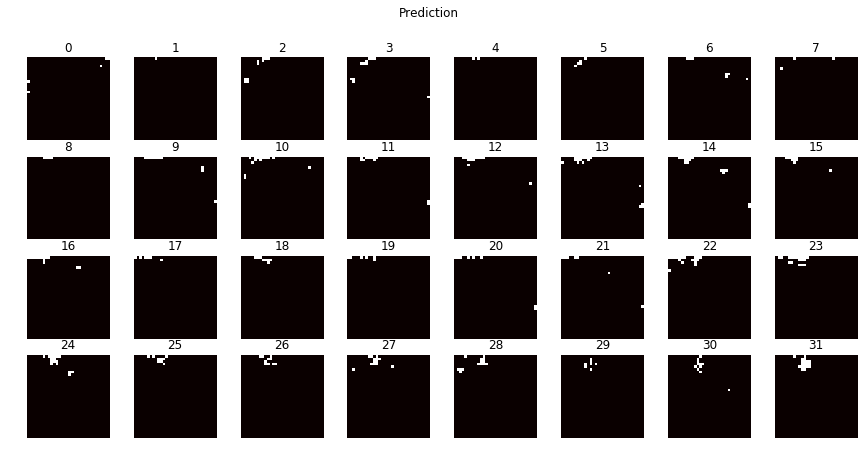

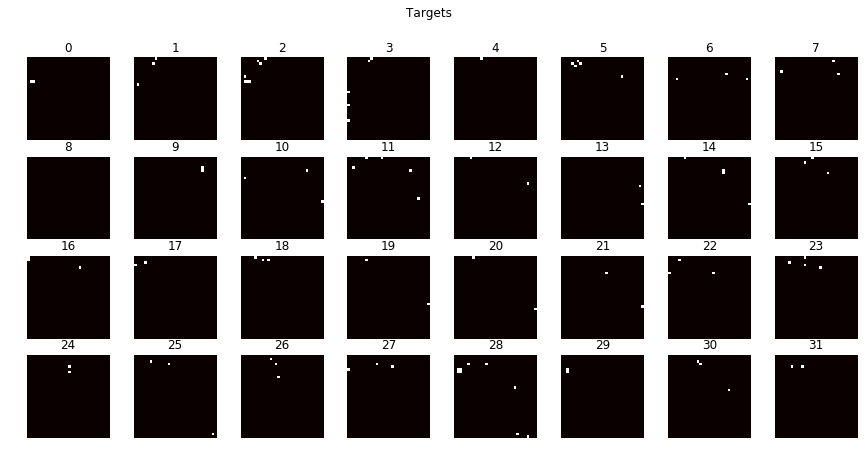

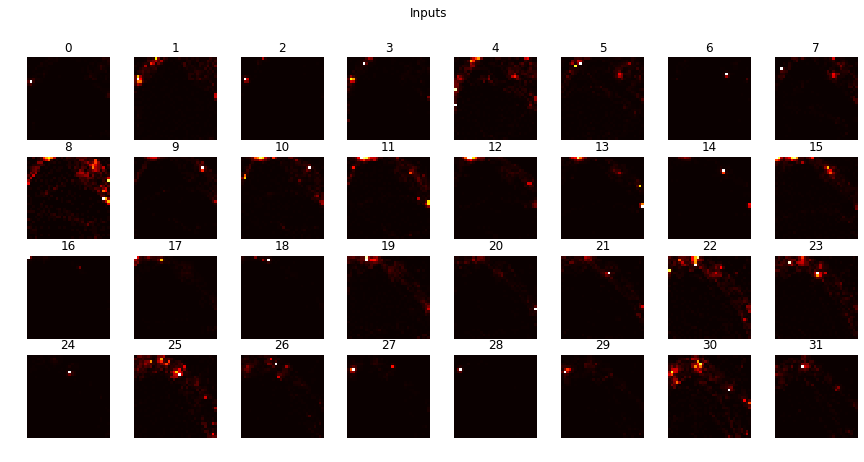

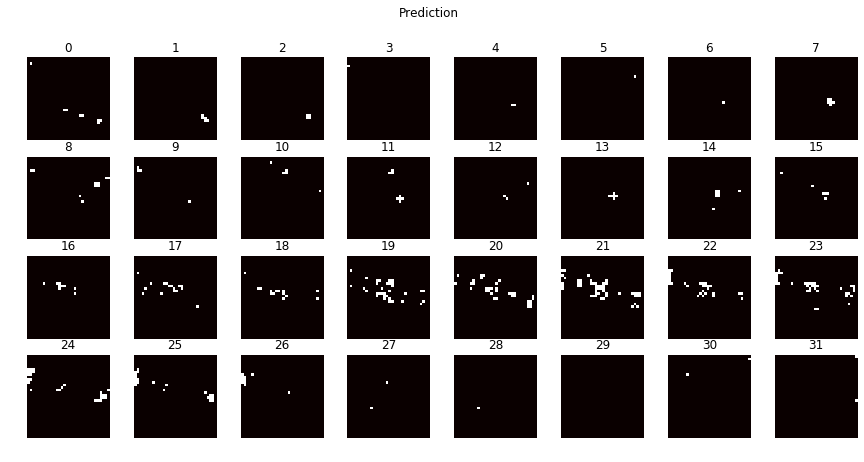

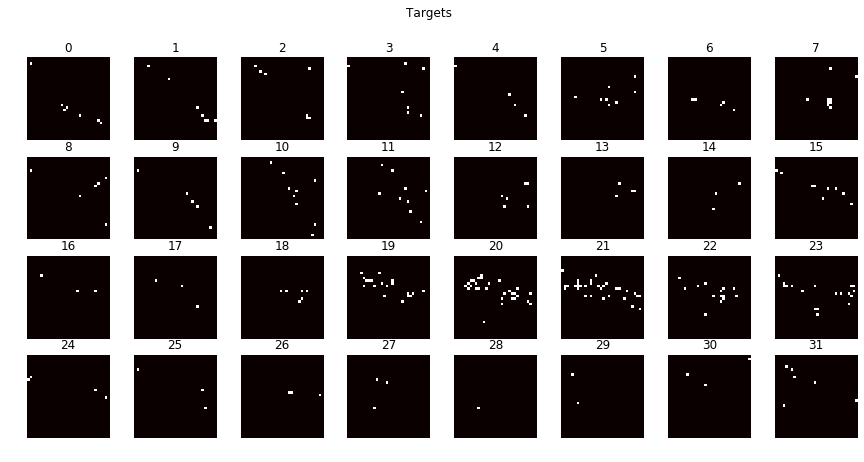

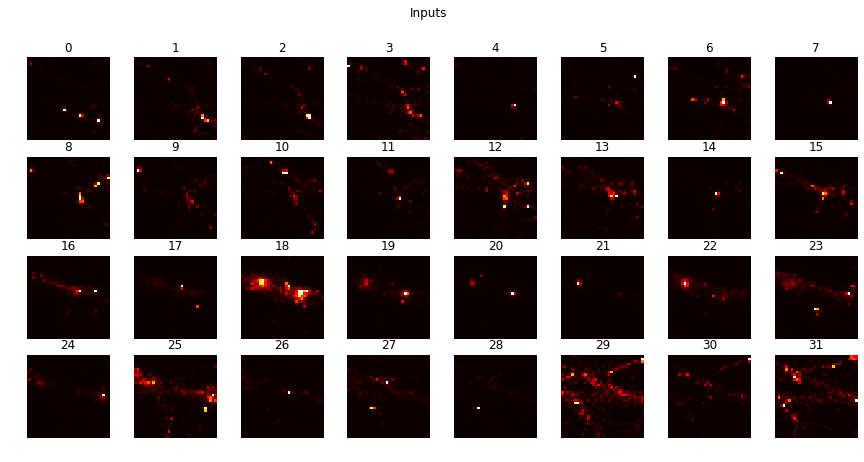

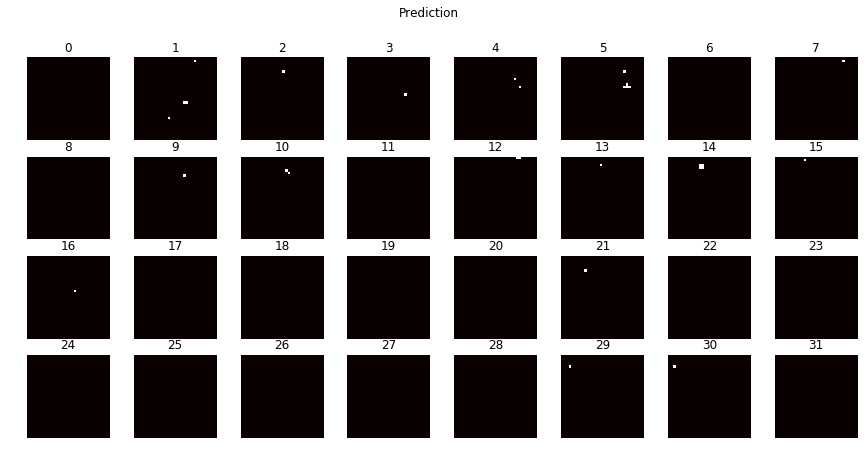

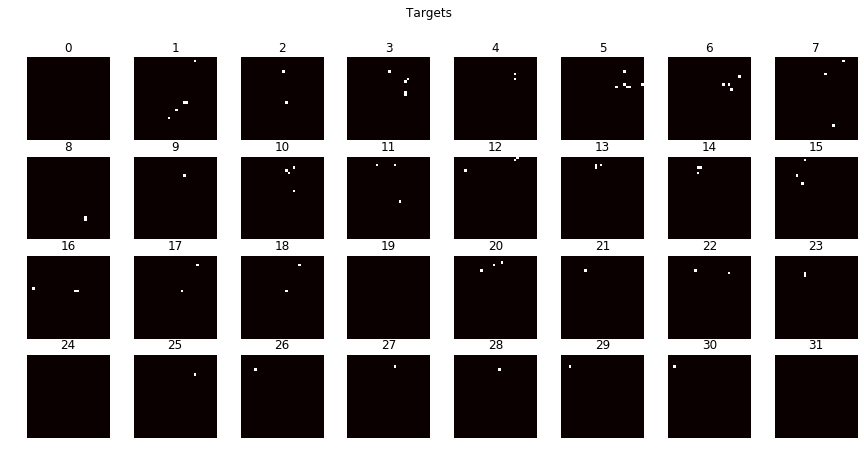

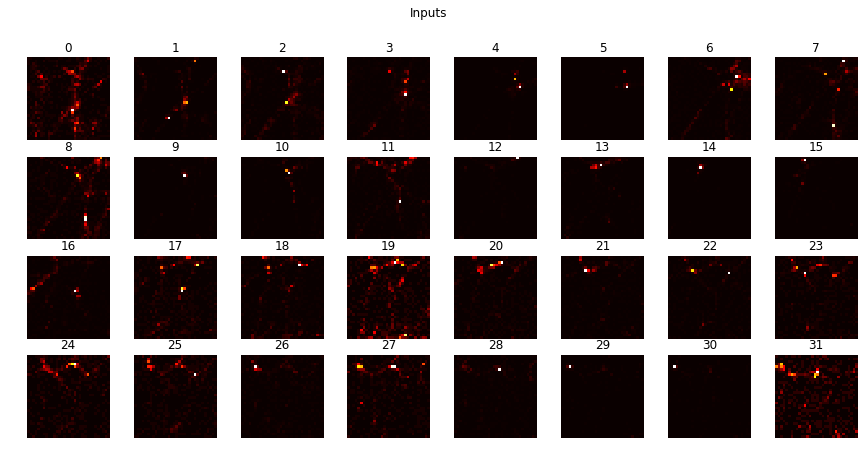

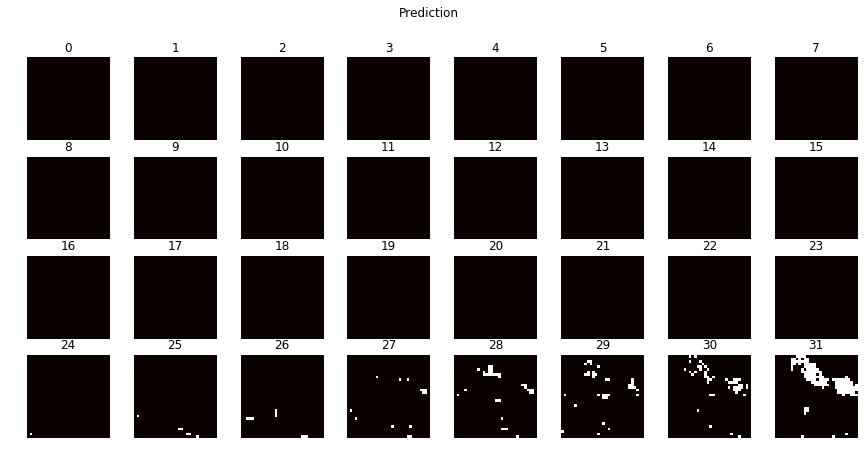

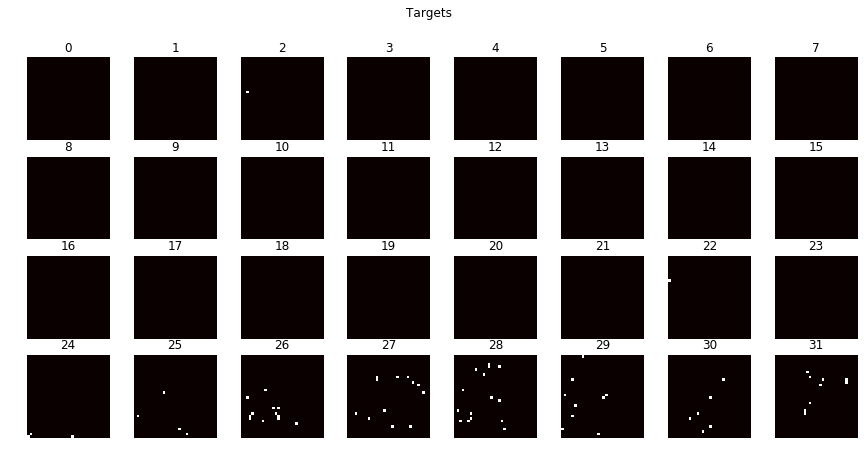

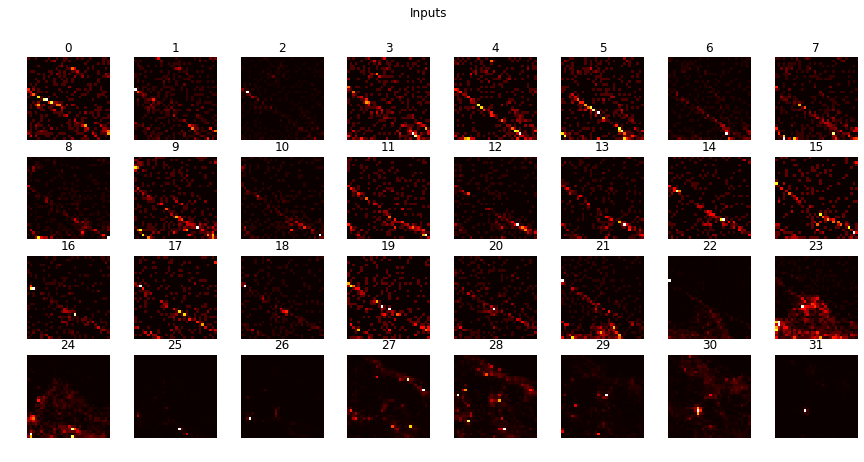

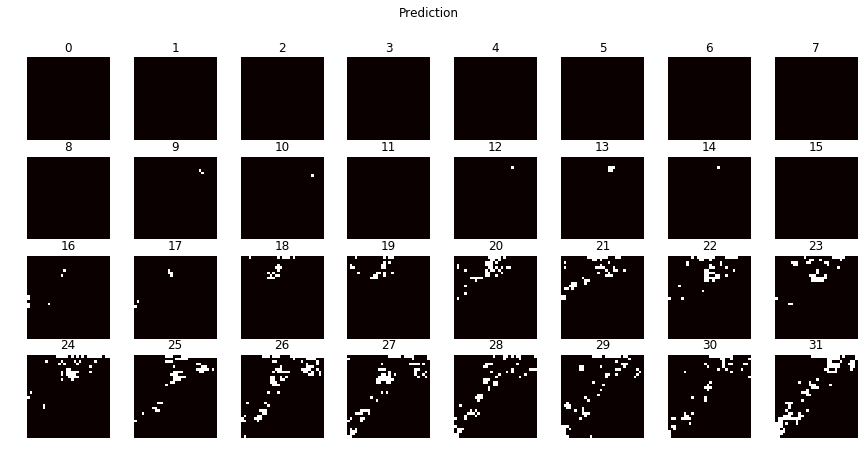

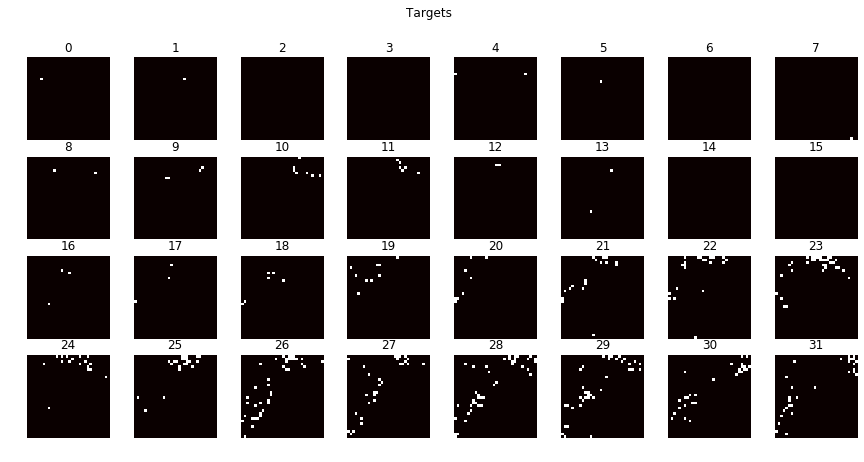

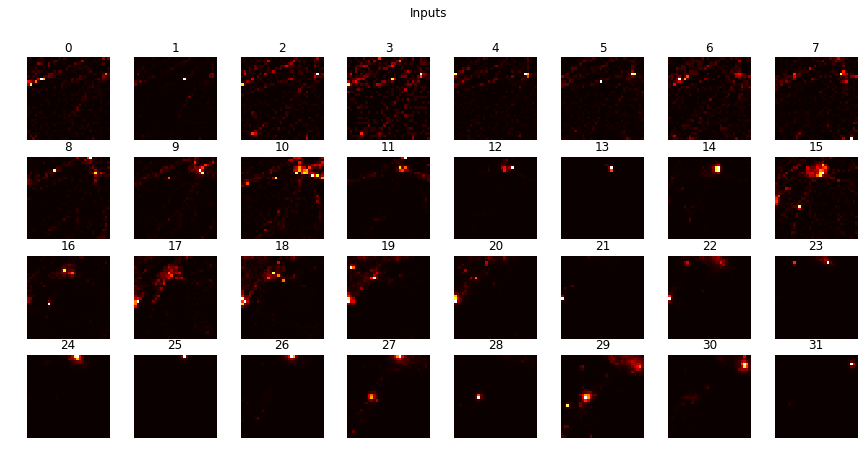

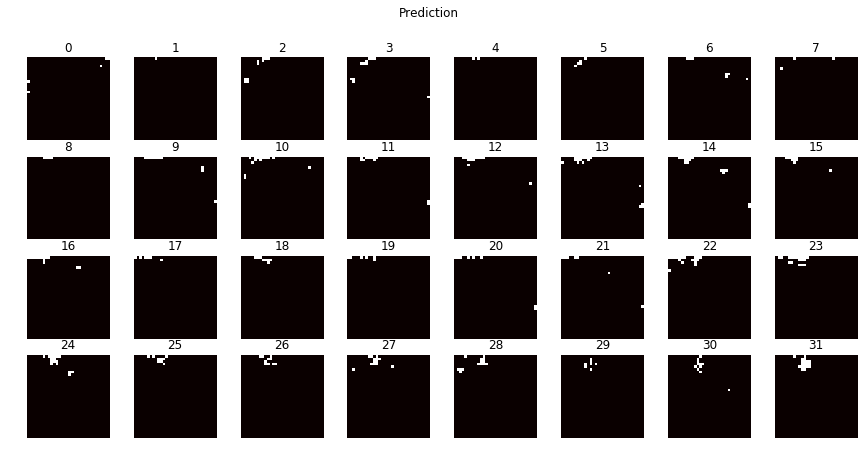

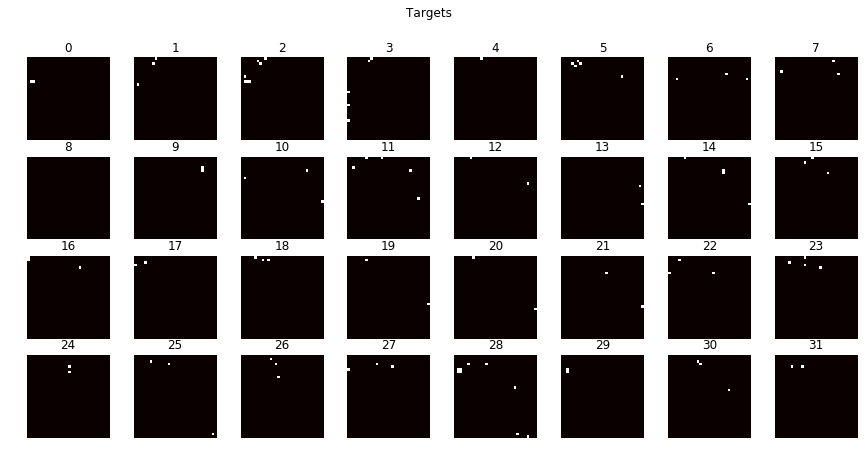

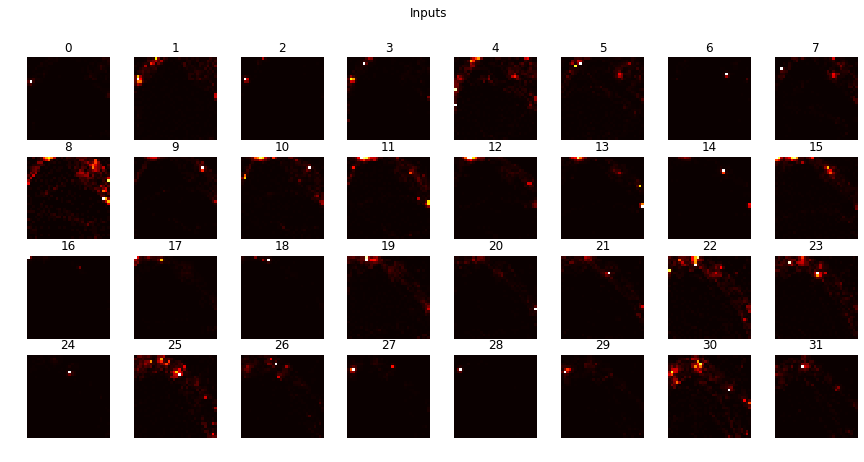

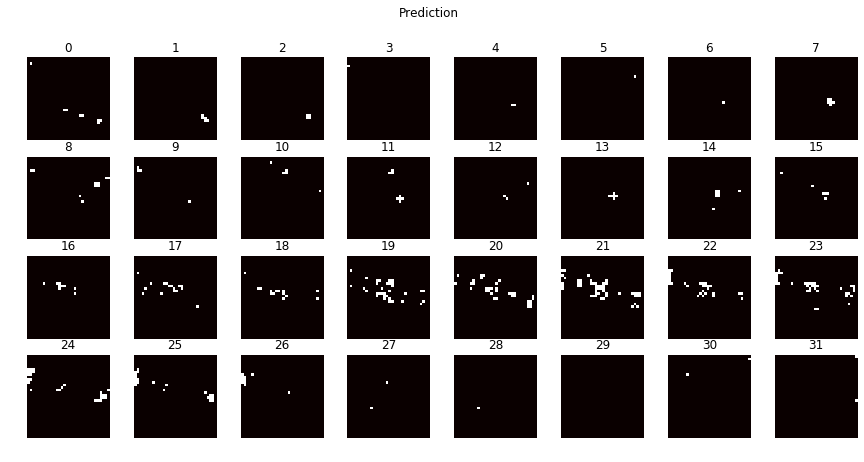

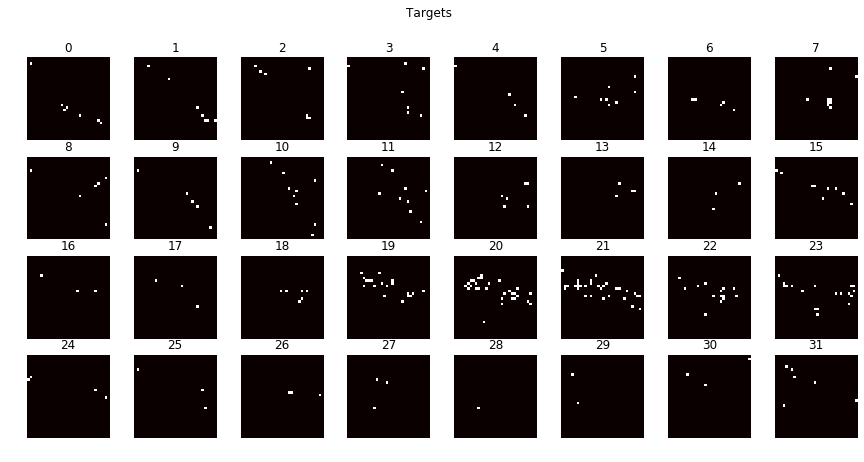

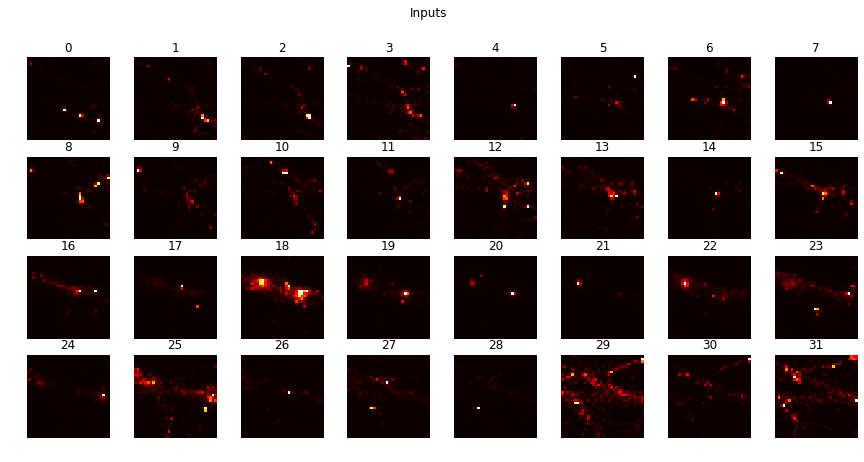

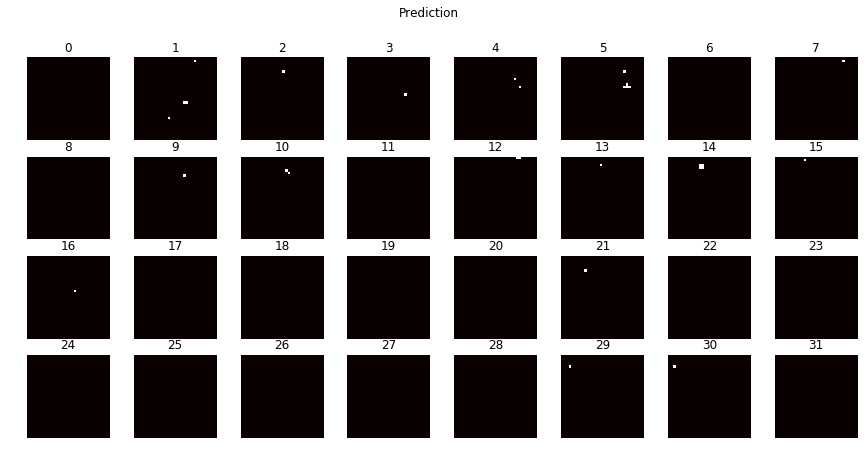

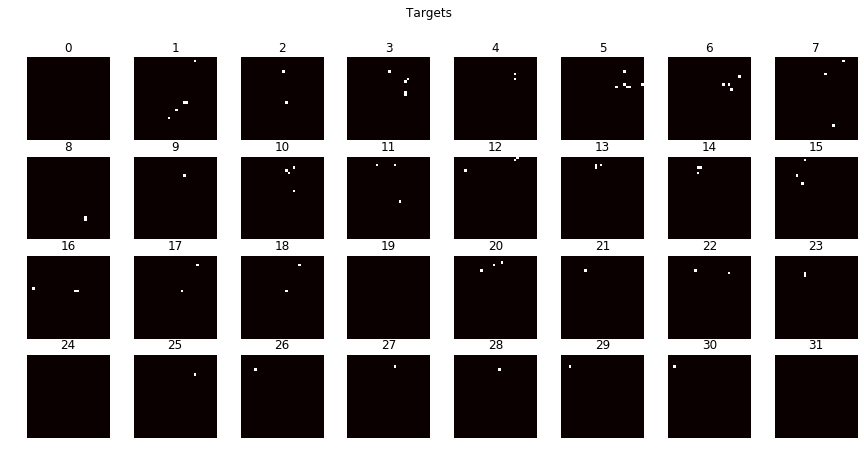

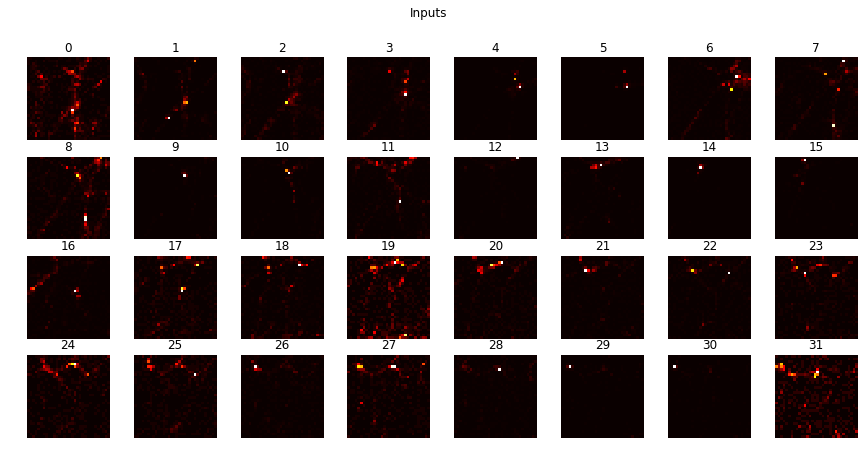

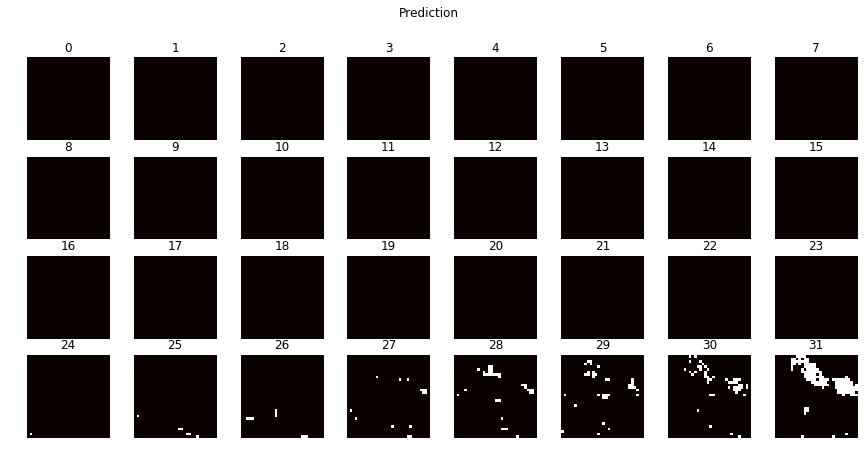

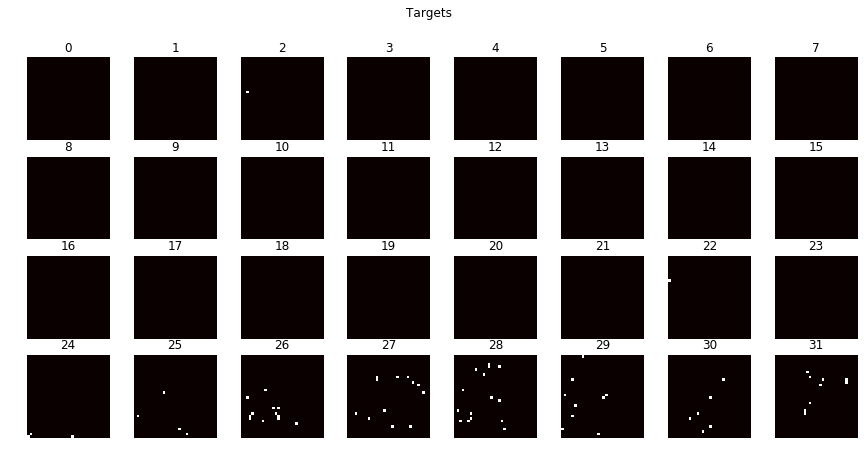

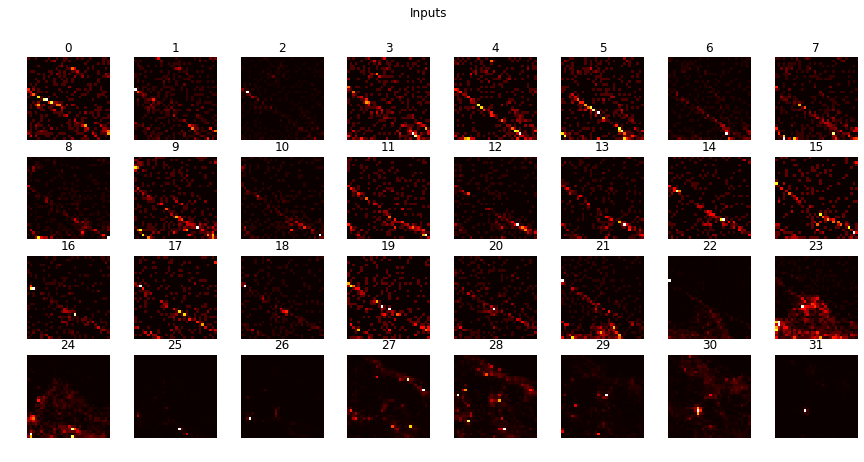

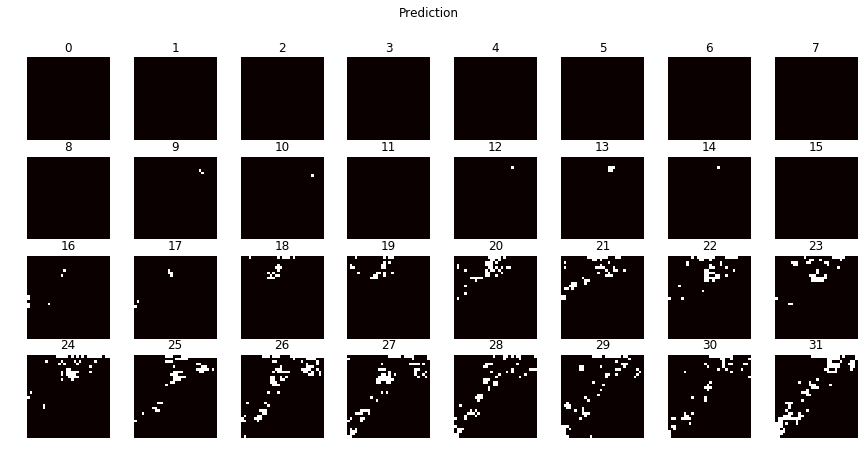

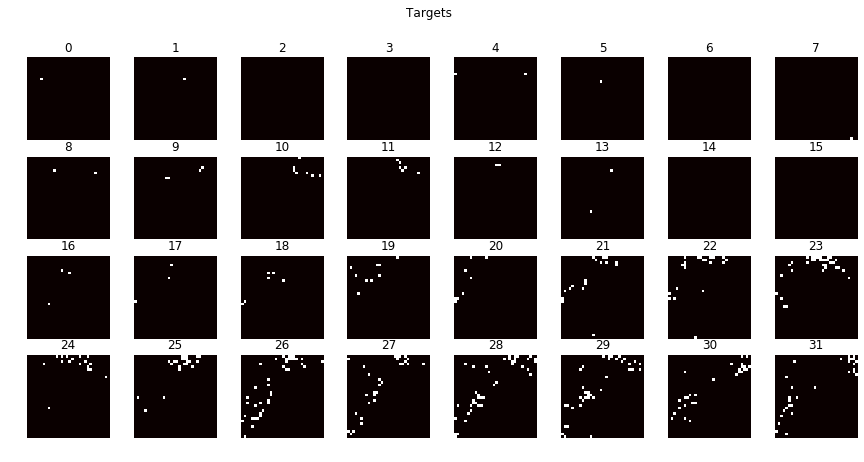

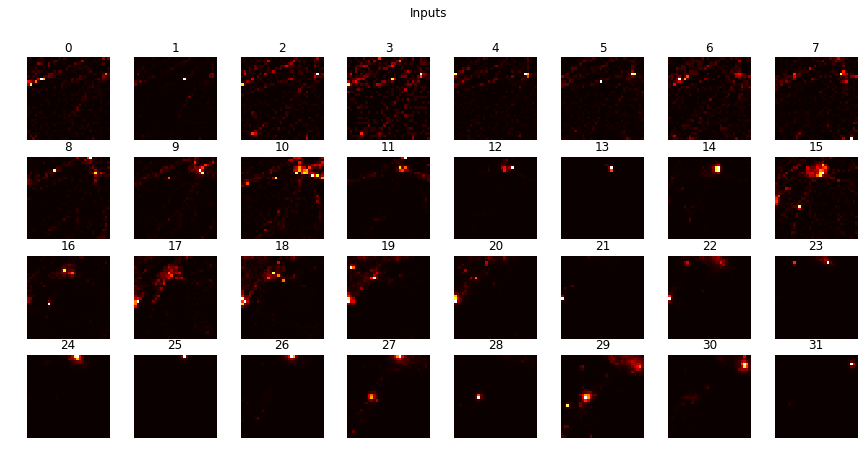

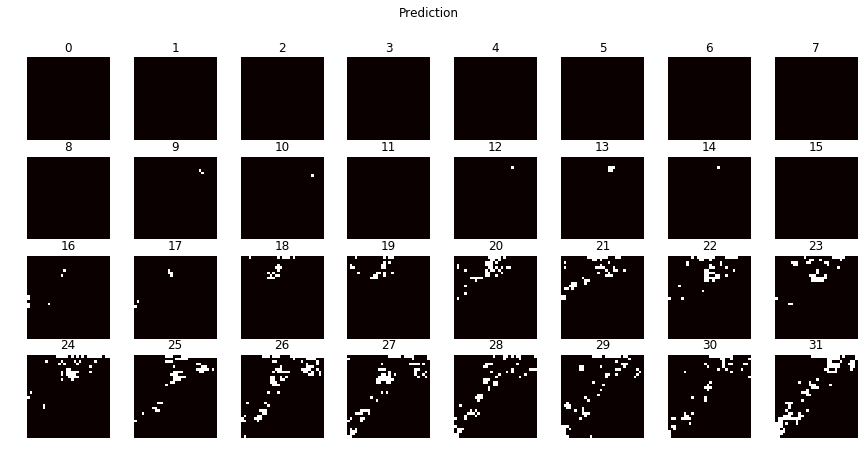

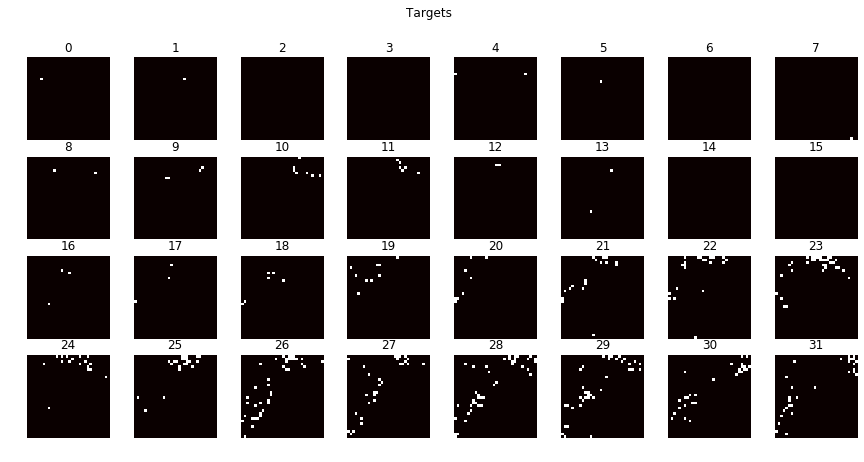

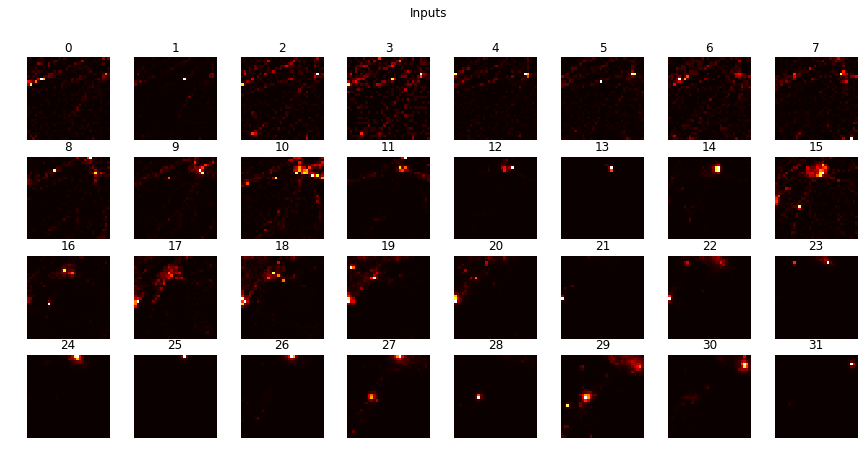

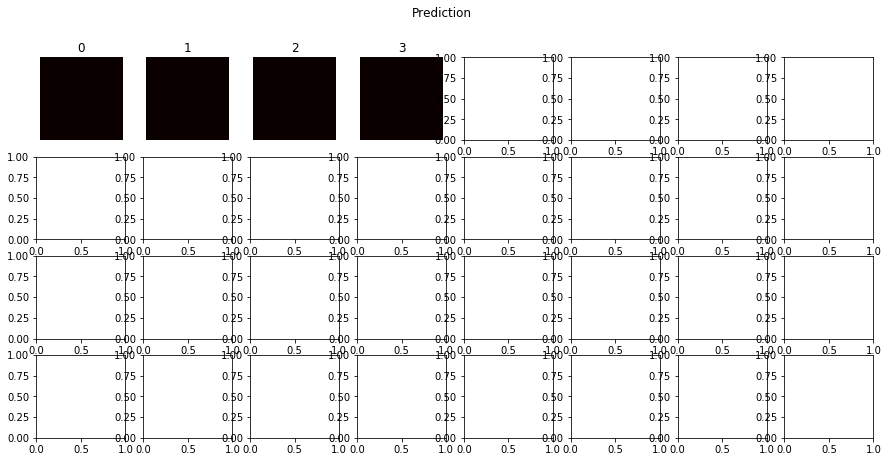

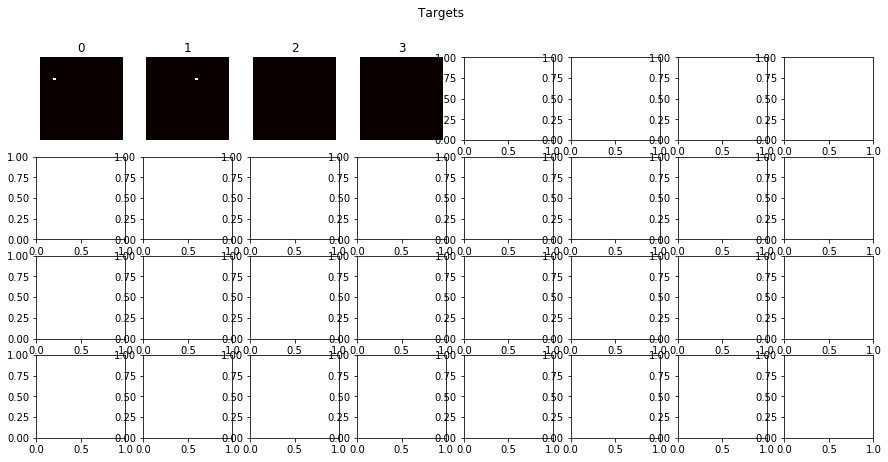

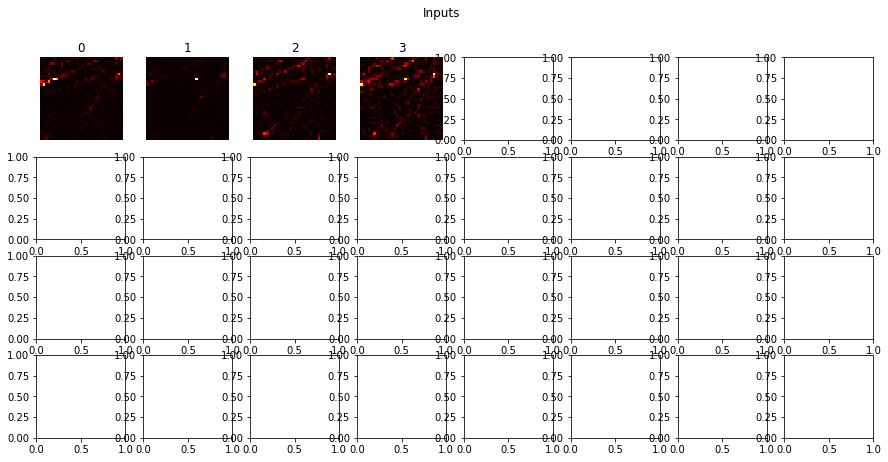

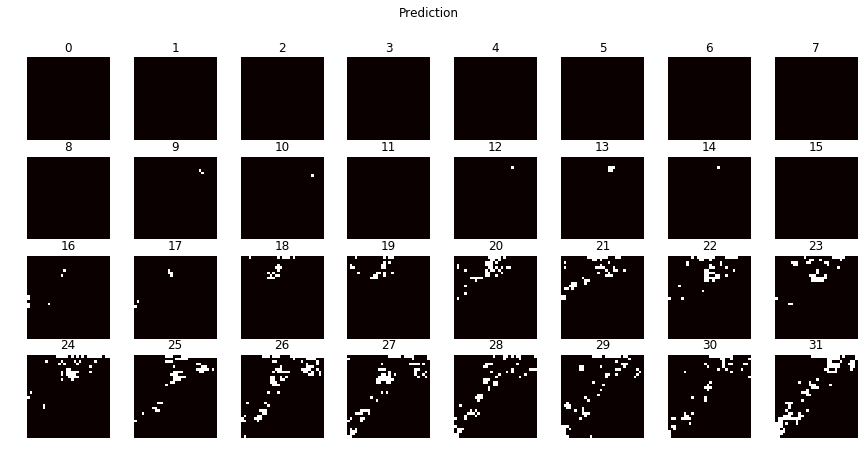

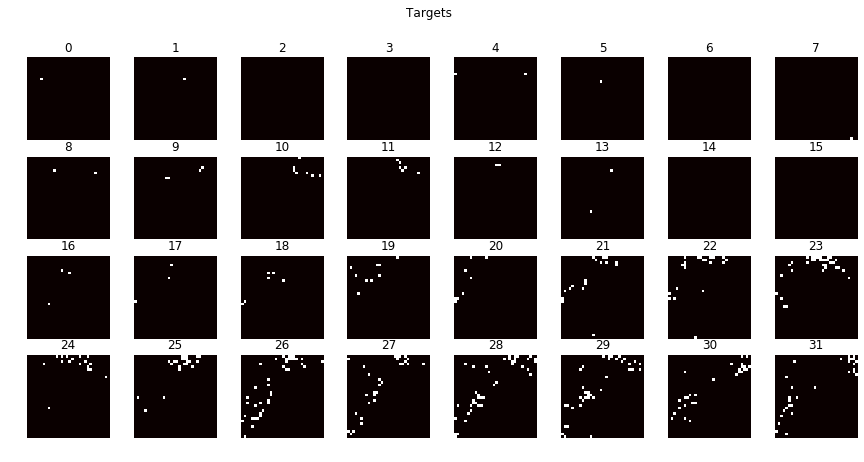

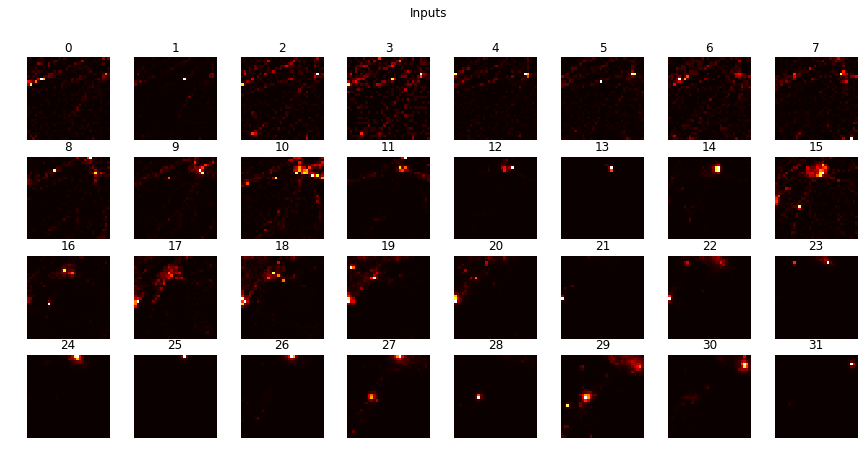

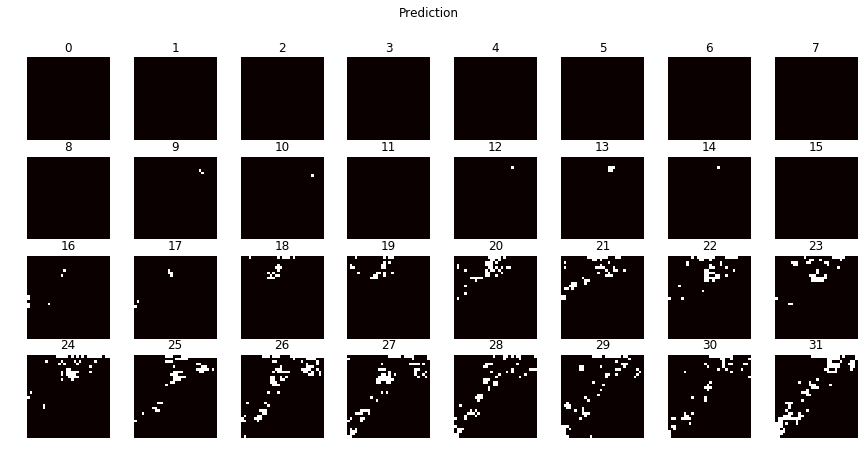

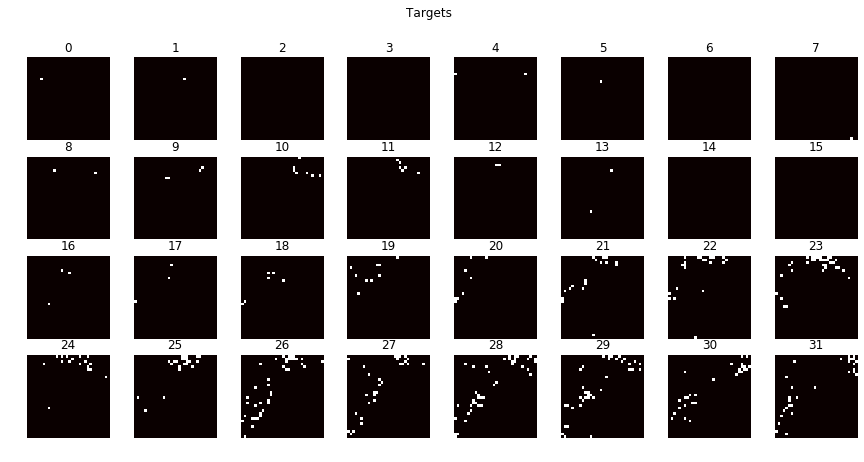

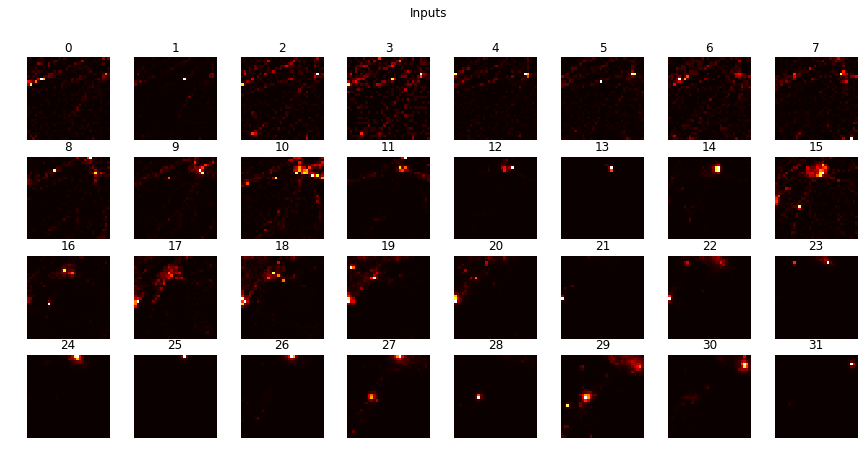

In [11]:
import matplotlib.pyplot as plt

##add on after defining Dataloader and Model

def visualize(predicted,target,inputs):
#     outputs = F.softmax(output, dim=1)
#     predicted = outputs.max(1, keepdim=True)[1]
    
    fig, axs = plt.subplots(4,8,figsize=(15,7))
    axs = axs.reshape(-1)
    fig.suptitle('Prediction')
    for i in range(32):
        img_arr = predicted[0,0,i,:,:]
        axs[i].imshow(img_arr, cmap='hot')
        axs[i].set_title('%d'%i)
        axs[i].set_axis_off()
        
    fig, axs = plt.subplots(4,8,figsize=(15,7))
    axs = axs.reshape(-1)
    fig.suptitle('Targets')
    for i in range(32):
        img_arr = target[0,i,:,:]
        axs[i].imshow(img_arr, cmap='hot')
        axs[i].set_title('%d'%i)
        axs[i].set_axis_off()

#     fig, axs = plt.subplots(4,8,figsize=(15,7))
#     axs = axs.reshape(-1)
#     fig.suptitle('Inputs')
#     for i in range(32):
#         img_arr = inputs[0,0,i,:,:]
#         axs[i].imshow(img_arr, cmap='hot')
#         axs[i].set_title('%d'%i)
#         axs[i].set_axis_off()
    
    plt.show()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#test_data=[(736, 256, 288), (800, 704, 288), (480, 480, 544), (608, 736, 736), (480, 928, 32)]
#test_data=[(512, 64, 800), (480, 192, 96), (704, 96, 896), (384, 672, 448), (64, 640, 384)]
test_data=[(512, 64, 800)]

# #build dataloader
params = {'batch_size': 1,
      'shuffle': False,
      'num_workers':20}
testing_set= Dataset(test_data)
testing_generator = data.DataLoader(testing_set, **params)

model.eval()
with torch.no_grad():
    for i, (inputs, target) in enumerate(testing_generator):
        inputs = inputs.unsqueeze(dim = 1).to(device).float()
        target = target.to(device).long()  
        output = model(inputs)
        outputs = F.softmax(output, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        dm_mean=5.614541471004486
        visualize(predicted,target,inputs) #*dm_mean+dm_mean)

In [177]:
state_dict = torch.load('check_pt/weight1_clf_t3_mv1_max_filter2.pth')

In [7]:
model = torch.load('../pretrained/mytraining.pt')

/home/ys3202/.conda/envs/dark/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'Models.Inception' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ys3202/.conda/envs/dark/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'Models.InceptionE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [1]:
'''

'''
dim = 1
model = R2Unet(dim, dim, t = 3, reg = 0).to(device) 
model.load_state_dict(state_dict)
criterion = nn.CrossEntropyLoss(weight = get_loss_weight(1, num_class= 2)).to(device) ##Models3
# inputs = torch.randn(1, 1, 32, 32, 32).uniform_(0, 1)
# output = model(inputs)

NameError: name 'R2Unet' is not defined

In [9]:
import matplotlib.pyplot as plt

##add on after defining Dataloader and Model

def visualize(predicted,target,inputs):
#     outputs = F.softmax(output, dim=1)
#     predicted = outputs.max(1, keepdim=True)[1]
    
    fig, axs = plt.subplots(4,8,figsize=(15,7))
    axs = axs.reshape(-1)
    fig.suptitle('Prediction')
    for i in range(32):
        img_arr = predicted[0,0,i,:,:]
        axs[i].imshow(img_arr, cmap='hot')
        axs[i].set_title('%d'%i)
        axs[i].set_axis_off()

    fig, axs = plt.subplots(4,8,figsize=(15,7))
    axs = axs.reshape(-1)
    fig.suptitle('Targets')
    for i in range(32):
        img_arr = target[0,i,:,:]
        axs[i].imshow(img_arr, cmap='hot')
        axs[i].set_title('%d'%i)
        axs[i].set_axis_off()

    fig, axs = plt.subplots(4,8,figsize=(15,7))
    axs = axs.reshape(-1)
    fig.suptitle('Inputs')
    for i in range(32):
        img_arr = inputs[0,0,i,:,:]
        axs[i].imshow(img_arr, cmap='hot')
        axs[i].set_title('%d'%i)
        axs[i].set_axis_off()
    

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#test_data=[(736, 256, 288), (800, 704, 288), (480, 480, 544), (608, 736, 736), (480, 928, 32)]
#test_data=[(512, 64, 800), (480, 192, 96), (704, 96, 896), (384, 672, 448), (64, 640, 384)]
test_data=[(512, 64, 800)]

# #build dataloader
params = {'batch_size': 1,
      'shuffle': False,
      'num_workers':20}
testing_set= Dataset(test_data)
testing_generator = data.DataLoader(testing_set, **params)

model.eval()
with torch.no_grad():
    for i, (inputs, target) in enumerate(testing_generator):
        inputs = inputs.unsqueeze(dim = 1).to(device).float()
        target = target.to(device).long()  
        output = model(inputs)
        outputs = F.softmax(output, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        dm_mean=5.614541471004486
        visualize(predicted,target,inputs) #*dm_mean+dm_mean)

/home/ys3202/.conda/envs/dark/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [127]:
def get_loss_weight(loss_weight, num_class):
    piece = 1/((num_class - 1) * loss_weight + 1)
    a = [1]
    a.extend([loss_weight] * (num_class - 1))
    return (torch.from_numpy(piece * np.array(a))).float()

In [150]:
get_loss_weight(, 2)

tensor([0.3333, 0.6667])